In [363]:
import gpxpy
import gpxpy.gpx
gpx = gpxpy.parse(open('data/tokyo-men.gpx','r'))
new_points = []
points = gpx.tracks[0].segments[0].points
for i, point in enumerate(points):
    if i==0:
        new_points.append(point)
    else:
        if point.latitude != points[i-1].latitude and point.longitude != points[i-1].longitude:
            new_points.append(point)
gpx.tracks[0].segments[0].points = new_points
open('data/tokyo-men.gpx','w').write(gpx.to_xml())
gpx = gpxpy.parse(open('data/tokyo-men.gpx','r'))
alts = [point.elevation for point in gpx.tracks[0].segments[0].points]

<AxesSubplot:>

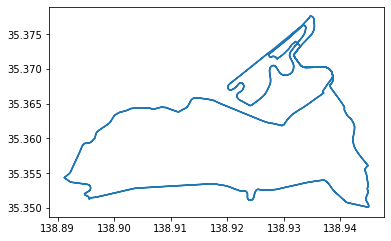

In [364]:
import geopandas as gpd
track = gpd.GeoDataFrame(columns=['name', 'geometry'], 
     geometry='geometry')
gdf = gpd.read_file('data/tokyo-men.gpx', layer='tracks')
gdf.plot()

In [365]:
gdf.head()

,name,cmt,desc,src,link1_href,link1_text,link1_type,link2_href,link2_text,link2_type,number,type,geometry
0,Tokyo 2020 Men Elite ITT,None,None,Generated by Anonymous using La Flamme Rouge t...,None,None,None,None,None,None,None,None,"MULTILINESTRING ((138.93119 35.37488, 138.9324..."


In [366]:
len(gdf.geometry[0].geoms[0].coords)

2282

In [367]:
#from shapely import geometry, ops
#singleline = ops.linemerge(gdf.geometry[0])
gdf.geometry[0]=gdf.geometry[0].geoms[0]

In [368]:
gdf.head()
print(gdf.geometry[0].coords[0])
gdf.crs

(138.93119, 35.37488)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

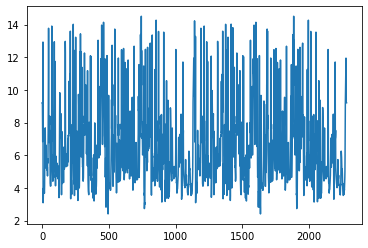

In [369]:
import pymap3d as pm
lat0 = gdf.geometry[0].coords[0][1]
lon0 = gdf.geometry[0].coords[0][0]
h0 = 0
lat = gdf.geometry[0].coords[1][1]
lon = gdf.geometry[0].coords[1][0]
h = 0
def get_local_coord(coord, coord0):
    lat0 = coord0[1]
    lon0 = coord0[0]
    lat = coord[1]
    lon = coord[0]
    return pm.geodetic2enu(lat, lon, 0, lat0, lon0, h0)[:2]
coords = gdf.geometry[0].coords
local_coords = [ get_local_coord(coord, coords[0]) for coord in coords]
local_coords

from scipy import optimize

x = [i[0] for i in local_coords[0:5]]
y = [i[1] for i in local_coords[0:5]]
x=[]
y=[]

# def calc_R(xc, yc, x, y):
#     """ calculate the distance of each 2D points from the center (xc, yc) """
#     return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = np.sqrt((x-c[0])**2 + (y-c[1])**2)
    return Ri - Ri.mean()

def get_radius(i, local_coords, k):
    if i<k:
        return 10000
    if i+k>=len(local_coords):
        return 10000
    point_set = local_coords[i-k:i+k]
    x = [i[0] for i in point_set]
    y = [i[1] for i in point_set]
    
    center_estimate = (np.mean(x),np.mean(y))
    center, ier = optimize.leastsq(f_2, center_estimate, args=(x, y))
    #print(ier)
    Ri_2       = calc_R(*center, x, y)
    R_2        = Ri_2.mean()
    return R_2

get_radius(190, local_coords, 100)
radii = [get_radius(i, local_coords, 3) for i in range(len(local_coords))]
plt.plot(np.log(radii))

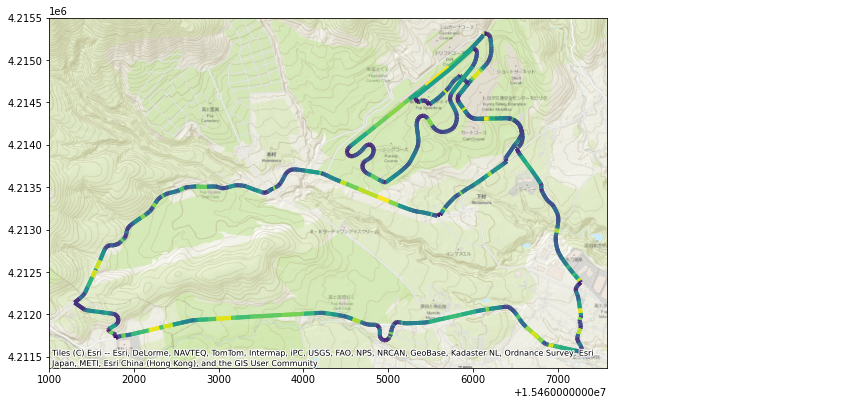

In [370]:
from shapely.geometry import Point
from shapely.geometry import LineString

import contextily as cx

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

line_segments = segments(gdf.geometry[0])
segment_radius = [(radii[i]+radii[i+1])/2 for i in range(len(radii)-1)]

tokyo_lines = gpd.GeoDataFrame(columns=['radius','geometry'],geometry='geometry')
tokyo_lines.geometry = line_segments
tokyo_lines.radius = np.log(segment_radius)

tokyo_lines.crs='epsg:4326'
tokyo_lines = tokyo_lines.to_crs(epsg=3857)
ax = tokyo_lines.plot(tokyo_lines.radius,linewidth=4,figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)
#tokyo.explore(tokyo.radius)

# Point(coords[0])
# tokyo = gpd.GeoDataFrame(columns=['radius', 'geometry'], 
#          geometry='geometry')
# points = [Point(coords[i]) for i in range(len(coords))]
# tokyo.geometry = points
# tokyo.radius = np.log(radii)
# tokyo.explore(tokyo.radius)

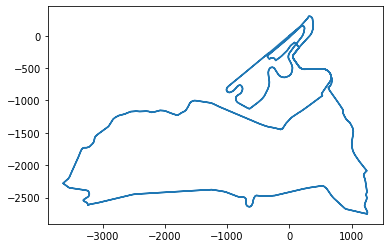

In [371]:
x = [i[0] for i in local_coords]
y = [i[1] for i in local_coords]
plt.plot(x,y)

In [372]:
# import sys
# sys.path.append('../elevation_profile')
# from ElevationSampler import DEM
# import pandas as pd
# from shapely.geometry import  LineString

# elevation_model = DEM("data/ASTGTMV003_N35E138_dem.tif")

# # define a line to sample along / or wrap in a geopandas GeoSeries for crs handling
# line = gdf.geometry[0]

# # sample every 10m along the line
# sample_distance = 10
# elevation_profile = elevation_model.elevation_profile(line, distance=sample_distance, interpolated=True)
# print(elevation_profile.inclination(degrees=True))

(138.93119, 35.37488)


1489.0

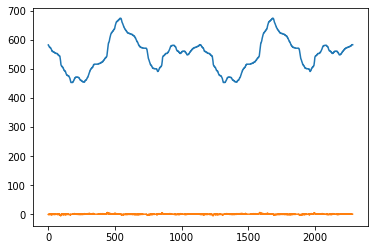

In [373]:
import srtm1
import matplotlib.pyplot as plt
# def coord_to_alt(coord):
#     lat = coord[1]
#     lon = coord[0]
#     return srtm1.read('data/ASTGTMV003_N35E138_dem.tif',lat, lon)



coord1 = gdf.geometry[0].coords[0]
print(coord1)
lat = coord1[1]
lon = coord1[0]
#alts = [coord_to_alt(coord) for coord in gdf.geometry[0].coords]
alt_diffs = [alts[i+1]-alts[i] for i in range(len(alts)-1)]
#dists = 
plt.plot(alts)
plt.plot(alt_diffs)
sum([abs(diff) for diff in alt_diffs])


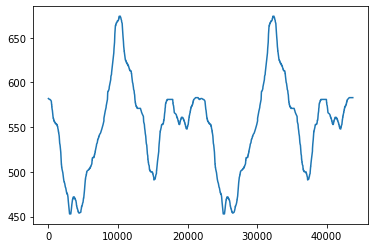

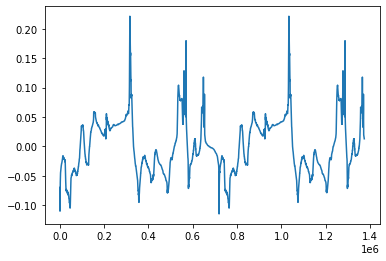

In [374]:
from haversine import haversine_vector, Unit
import numpy as np
coords_latlon = [x[::-1] for x in gdf.geometry[0].coords]
dists = haversine_vector(coords_latlon[1:],coords_latlon[:-1], Unit.METERS)
slopes = alt_diffs/dists #too noisy!
sum(dists)
cum_dists = np.insert(np.cumsum(dists),0,0)
smoothing = 40
alt_diffs_smooth = [alts[i+smoothing]-alts[i] for i in range(len(alts)-smoothing)]
dists_smooth = haversine_vector(coords_latlon[smoothing:],coords_latlon[:-smoothing], Unit.METERS)
slopes = alt_diffs_smooth/dists_smooth
cum_dists_smooth = np.cumsum(dists_smooth)
#todo: calculate slopes CENTERED around points

plt.plot(cum_dists,alts)
plt.show()
plt.plot(cum_dists_smooth,slopes)

In [375]:
np.argmin(dists)

14

In [376]:
type(line)

shapely.geometry.linestring.LineString

In [377]:

sys.path.append('../SRTM-GeoTIFF/library')

In [378]:
import tilename
tilename.find(gdf.geometry[0].coords[0][1],gdf.geometry[0].coords[0][0])

'N35E138.tif'